# Práctica 3. Detección de formas

Práctica realizada por: Alejandro Rodríguez Moreno y Nauzet Déniz Perdomo

In [1]:
import cv2  
import math
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)

In [2]:
#Carga imagen ejemplo con monedas
img = cv2.imread('images/Monedas 1.jpeg') 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('images/Monedas 3.jpeg') 
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


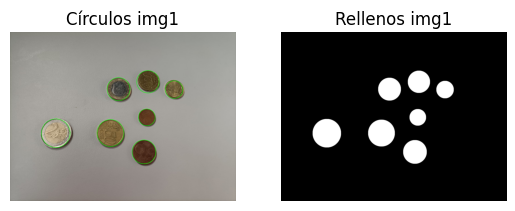

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


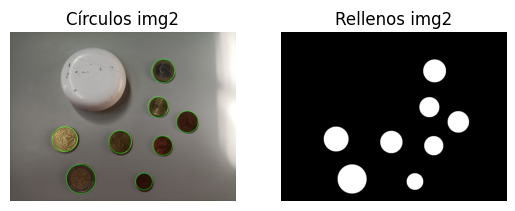

Hay 7 monedas en la primera imagen, y 8 en la segunda.


In [3]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gris2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
pimg2 = cv2.medianBlur(gris2, 7)

#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=70, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Localiza Círculos
circ2 = cv2.HoughCircles(
        pimg2,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=70, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=40,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numMonedas1 = 0
for det in circ[0]:
    numMonedas1+=1
    x_coor, y_coor, det_radio = det
    cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
        int(det_radio),(0, 255, 0), 2)
    cv2.circle(img_cont,(int(x_coor), int(y_coor)),
        int(det_radio),(255, 255, 255), -1)
        
#Dibuja sobre entrada  e imagen vacía
img_cont2 = np.zeros(img_rgb2.shape)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
numMonedas2 = 0
for det2 in circ2[0]:
    numMonedas2+=1
    x_coor2, y_coor2, det_radio2 = det2
    cv2.circle(img_rgb2,(int(x_coor2), int(y_coor2)),
        int(det_radio2),(0, 255, 0), 2)
    cv2.circle(img_cont2,(int(x_coor2), int(y_coor2)),
        int(det_radio2),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos img1')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos img1')

plt.show()

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb2) 
plt.title('Círculos img2')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont2) 
plt.title('Rellenos img2')

plt.show()

print("Hay", numMonedas1, "monedas en la primera imagen, y",numMonedas2,"en la segunda.")

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


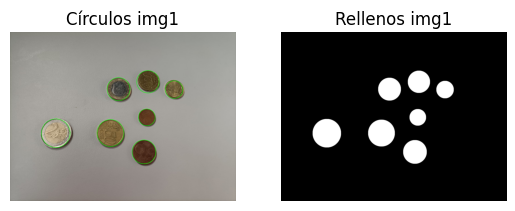

En la primera imagen en total hay 3.86 Euros


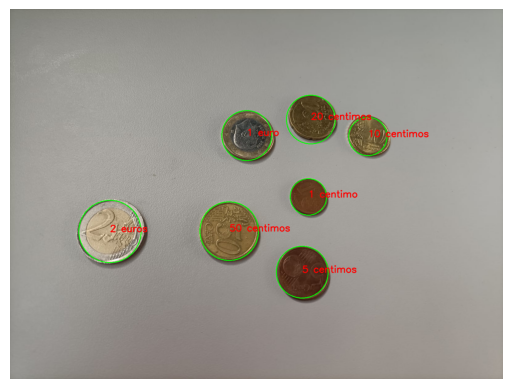

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


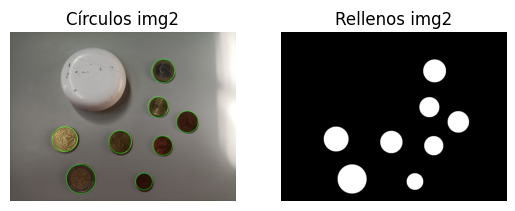

En la segunda imagen en total hay 3.88 Euros


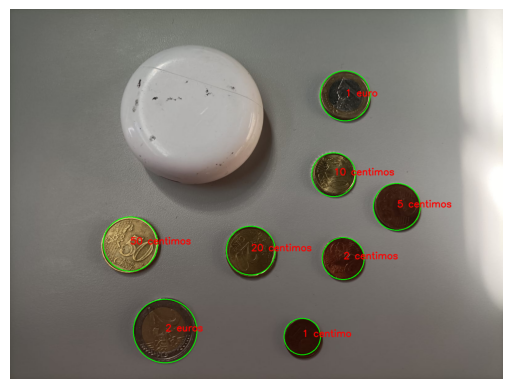

In [4]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 

# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2

xCoord = 0
yCoord = 0

def click_event(event, x, y, flags, params): 
  
    # checking for left mouse clicks 
    if event == cv2.EVENT_LBUTTONDOWN: 
        global xCoord
        global yCoord
        xCoord = x
        yCoord = y
        cv2.destroyAllWindows()
        
  
# displaying the image 
cv2.imshow('image', img_rgb) 

# setting mouse handler for the image 
# and calling the click_event() function 
cv2.setMouseCallback('image', click_event) 

# wait for a key to be pressed to exit 
cv2.waitKey(0) 

# close the window 
cv2.destroyAllWindows() 

plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos img1')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos img1')

plt.show()

euroRadio = 0
euroCoord = (0,0)
for det in circ[0]:
    center_x, center_y, radio = det
    if(math.sqrt((xCoord - center_x) ** 2 + (yCoord - center_y) ** 2) <= radio):
        euroRadio = radio
        euroCoord = (center_x, center_y)

dinero = 0
for det in circ[0]:
    center_x, center_y, radio = det

    if((center_x, center_y) == euroCoord):
        dinero += 1
        img_rgb = cv2.putText(img_rgb, '1 euro', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.30 and radio >= euroRadio*1.21):
        dinero += 2
        img_rgb = cv2.putText(img_rgb, '2 euros', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.21 and radio >= euroRadio*1.07):
        dinero += 0.5
        img_rgb = cv2.putText(img_rgb, '50 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.07 and radio >= euroRadio*1.01):
        dinero += 0.05
        img_rgb = cv2.putText(img_rgb, '5 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.01 and radio >= euroRadio*0.93):        
        dinero += 0.2
        img_rgb = cv2.putText(img_rgb, '20 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.93 and radio >= euroRadio*0.76):
        dinero += 0.1
        img_rgb = cv2.putText(img_rgb, '10 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.76 and radio >= euroRadio*0.68):
        dinero += 0.01
        img_rgb = cv2.putText(img_rgb, '1 centimo', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    else:
        img_rgb = cv2.putText(img_rgb, 'nada', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    
print("En la primera imagen en total hay", dinero, "Euros")
plt.plot()
plt.axis("off")
plt.imshow(img_rgb)
plt.show()
# displaying the image 
cv2.imshow('image', img_rgb2) 

# setting mouse handler for the image 
# and calling the click_event() function 
cv2.setMouseCallback('image', click_event) 

# wait for a key to be pressed to exit 
cv2.waitKey(0) 

# close the window 
cv2.destroyAllWindows() 

plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb2) 
plt.title('Círculos img2')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont2) 
plt.title('Rellenos img2')

plt.show()

euroRadio = 0
euroCoord = (0,0)
for det2 in circ2[0]:
    center_x, center_y, radio = det2
    if(math.sqrt((xCoord - center_x) ** 2 + (yCoord - center_y) ** 2) <= radio):
        euroRadio = radio
        euroCoord = (center_x, center_y)

dinero = 0
image = img_rgb2

for det2 in circ2[0]:
    center_x, center_y, radio = det2
    if((center_x, center_y) == euroCoord):
        dinero += 1
        img_rgb2 = cv2.putText(img_rgb2, '1 euro', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.30 and radio >= euroRadio*1.21):
        dinero += 2
        img_rgb2 = cv2.putText(img_rgb2, '2 euros', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.21 and radio >= euroRadio*1.07):
        dinero += 0.5
        img_rgb2 = cv2.putText(img_rgb2, '50 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*1.07 and radio >= euroRadio*0.97):
        dinero += 0.2
        img_rgb2 = cv2.putText(img_rgb2, '20 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.97 and radio >= euroRadio*0.93):
        dinero += 0.05
        img_rgb2 = cv2.putText(img_rgb2, '5 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.93 and radio >= euroRadio*0.85):
        dinero += 0.1
        img_rgb2 = cv2.putText(img_rgb2, '10 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.85 and radio >= euroRadio*0.76):
        dinero += 0.02
        img_rgb2 = cv2.putText(img_rgb2, '2 centimos', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    elif(radio <= euroRadio*0.76 and radio >= euroRadio*0.68):
        dinero += 0.01
        img_rgb2 = cv2.putText(img_rgb2, '1 centimo', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 
    else:
        img_rgb2 = cv2.putText(img_rgb2, 'nada', (round(center_x), round(center_y)), font, fontScale, color, thickness, cv2.LINE_AA) 

print("En la segunda imagen en total hay", dinero, "Euros")

plt.plot()
plt.axis("off")
plt.imshow(img_rgb2)
plt.show()

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

(942, 1170, 3)


Text(0.5, 1.0, 'OTSU invertida')

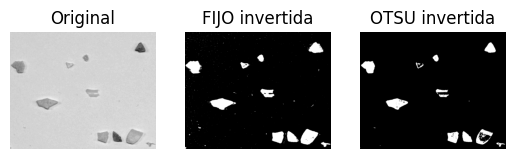

In [5]:
img = cv2.imread('images/FRA.png') 
print(img.shape)
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Dos umbralizados.
umbral = 130
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Umbralizado con método de Otsu
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 

plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


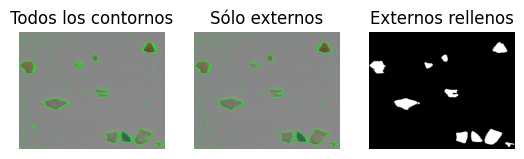

In [6]:

contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
geometrias = []
for c in contornos2:
    #Área delcontorno
    area = cv2.contourArea(c)

    #Dimensión mínima (útil en ocasiones)
    if area > 150:
        #Perímetro delcontorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que lo contiene
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)

        # Compacidad que es la relación entre el cuadrado del perímetro y el área
        compacidad = perimetro**2/area
        # Área del contenedor
        areaCont = w * h
        # Relación entre el área del contorno y la del contenedor
        relAreas = area / areaCont
        # Relación entre las dimensiones del contenedor
        relDimContenedor = w / h
        # Relación entre los ejes de la elipse
        relEjesElipse = elipse[1][0]/elipse[1][1]
        # Calcular el centroide del objeto
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        # Relación entre la mayor y la menor distancia al contorno desde el centroide
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max

        geometrias.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,0])

        #Para determinadas tareas nos interesará mostrar estos 
        # print(area, perimetro, rect, cx,cy,radio, elipse)
        # print(area, perimetro, compacidad, relAreas, relDimContenedor, relEjesElipse, relDistancias)
        

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Text(0.5, 1.0, 'OTSU invertida')

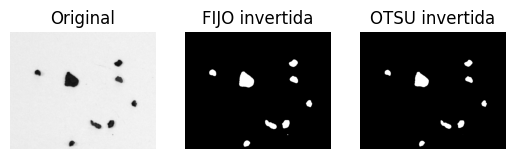

In [7]:
img = cv2.imread('images/TAR.png') 

img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
umbral = 100
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


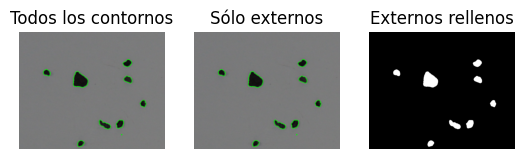

In [8]:

contornos, hierarchy = cv2.findContours(
    img_th1,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
for c in contornos2:

    area = cv2.contourArea(c)
    
    if area > 50:
        perimetro = cv2.arcLength(c,True)
        x,y,w,h = cv2.boundingRect(c)
        rect = cv2.minAreaRect(c)
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
        compacidad = perimetro**2/area
        areaCont = w * h
        relAreas = area / areaCont
        relDimContenedor = w / h
        relEjesElipse = elipse[1][0]/elipse[1][1]
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max

        geometrias.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,1])
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

Text(0.5, 1.0, 'OTSU invertida')

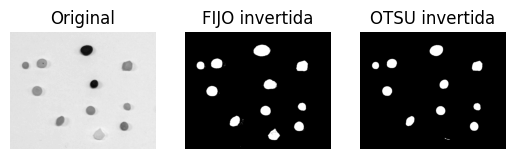

In [9]:
img = cv2.imread('images/PEL.png')
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
umbral = 111
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


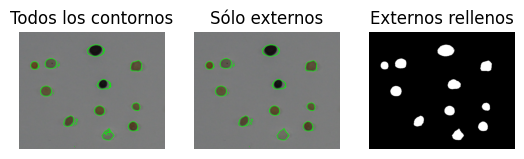

In [10]:
contornos, hierarchy = cv2.findContours(
    img_th1,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
for c in contornos2:
    area = cv2.contourArea(c)

    if area > 50:
        perimetro = cv2.arcLength(c,True)
        x,y,w,h = cv2.boundingRect(c)
        rect = cv2.minAreaRect(c)
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
        compacidad = perimetro**2/area
        areaCont = w * h
        relAreas = area / areaCont
        relDimContenedor = w / h
        relEjesElipse = elipse[1][0]/elipse[1][1]
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max

        geometrias.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,2])
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

In [11]:
img = cv2.imread('images/fragment-03-olympus-10-01-2020.JPG')
altura, ancho = img.shape[:2]
img = cv2.resize(img, (int(altura*0.4), int(ancho*0.4)))
altura, ancho = img.shape[:2]
colorFondo = np.mean(img[0:50, 0:50], axis=(0, 1))

img = img[0:altura-420, :]
img[altura-720:altura, ancho-350:ancho] = colorFondo
img[altura-580:altura, ancho-400:ancho] = colorFondo
img[altura-580:altura, 0:640] = colorFondo
img[altura-840:altura-580, 0:400] = colorFondo

Text(0.5, 1.0, 'OTSU invertida')

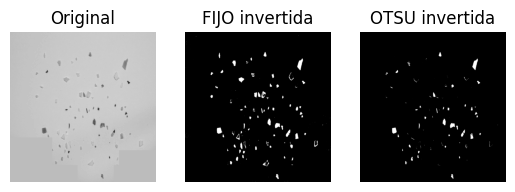

In [12]:
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
umbral = 123
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


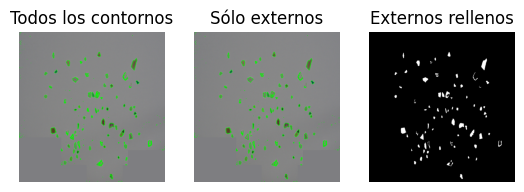

In [13]:
contornos, hierarchy = cv2.findContours(
    img_th1,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
fragmentTest = []
for c in contornos2:
    area = cv2.contourArea(c)

    if area > 50 and area:
        perimetro = cv2.arcLength(c,True)
        x,y,w,h = cv2.boundingRect(c)
        rect = cv2.minAreaRect(c)
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
        compacidad = perimetro**2/area
        areaCont = w * h
        relAreas = area / areaCont
        relDimContenedor = w / h
        relEjesElipse = elipse[1][0]/elipse[1][1]
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max
        fragmentTest.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,0])
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

In [14]:
img = cv2.imread('images/tar-03-olympus-10-01-2020.JPG')
altura, ancho = img.shape[:2]
img = cv2.resize(img, (int(altura*0.4), int(ancho*0.4)))
altura, ancho = img.shape[:2]

img = img[0:altura-420, :]

Text(0.5, 1.0, 'OTSU invertida')

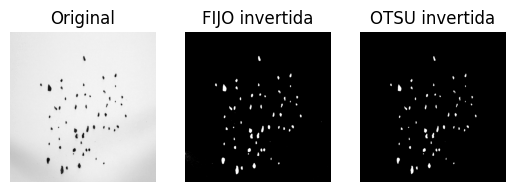

In [15]:
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
umbral = 100
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


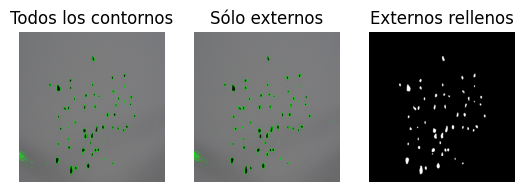

In [16]:
contornos, hierarchy = cv2.findContours(
    img_th1,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
tarTest = []
for c in contornos2:
    area = cv2.contourArea(c)

    if area > 50 and area:
        perimetro = cv2.arcLength(c,True)
        x,y,w,h = cv2.boundingRect(c)
        rect = cv2.minAreaRect(c)
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
        compacidad = perimetro**2/area
        areaCont = w * h
        relAreas = area / areaCont
        relDimContenedor = w / h
        relEjesElipse = elipse[1][0]/elipse[1][1]
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max
        tarTest.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,1])
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

In [17]:
img = cv2.imread('images/pellet-03-olympus-10-01-2020.JPG')
altura, ancho = img.shape[:2]
img = cv2.resize(img, (int(altura*0.4), int(ancho*0.4)))
altura, ancho = img.shape[:2]

img = img[0:altura-420, 140:]

Text(0.5, 1.0, 'OTSU invertida')

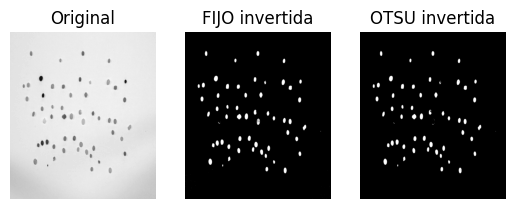

In [18]:
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
umbral = 100
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


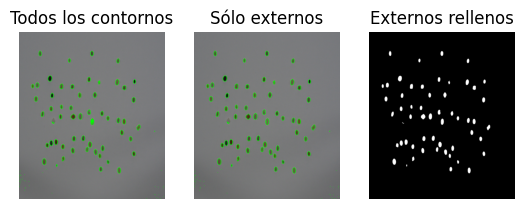

In [19]:
contornos, hierarchy = cv2.findContours(
    img_th1,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

img_cont = np.zeros(img_rgb.shape)
pelTest = []
for c in contornos2:
    area = cv2.contourArea(c)

    if area > 50 and area:
        perimetro = cv2.arcLength(c,True)
        x,y,w,h = cv2.boundingRect(c)
        rect = cv2.minAreaRect(c)
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
        compacidad = perimetro**2/area
        areaCont = w * h
        relAreas = area / areaCont
        relDimContenedor = w / h
        relEjesElipse = elipse[1][0]/elipse[1][1]
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        distancias = []
        for punto in c:
            x, y = punto[0]
            distancia = np.sqrt((x - cx)**2 + (y - cy)**2)
            distancias.append(distancia)
        dist_min = min(distancias)
        dist_max = max(distancias)
        relDistancias = dist_min / dist_max
        pelTest.append([area,perimetro,compacidad,relAreas,relDimContenedor,relEjesElipse,2])
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()

In [20]:
data = np.array(geometrias)
xTrain = data[:,:-1]
yTrain = data[:,-1]
test = fragmentTest + tarTest + pelTest
data = np.array(test)
xTest = data[:,:-1]
yTest = data[:,-1]

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xTrain,yTrain)
yPredKN = knn.predict(xTest)

In [22]:
from sklearn.svm import SVC

svcClass = SVC(kernel='linear')
svcClass.fit(xTrain,yTrain)
yPredSvcClass = svcClass.predict(xTest)

In [23]:
svcClassRbf = SVC(kernel='rbf', C=15,gamma=0.05)
svcClassRbf.fit(xTrain, yTrain)
yPredSvcClassRbf = svcClassRbf.predict(xTest)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rfcClass = RandomForestClassifier(n_estimators=100)
rfcClass.fit(xTrain, yTrain)
yPredRfcClass = rfcClass.predict(xTest)

Accuracy (TP/(n))= 0.3956043956043956
Precision (TP/(TP+FP)) = 0.2579961937503837
Recall (TP/(TP+FN)) = 0.3956043956043956
F1 Score (2*(precision*recall)/(precision+recall)) = 0.2364266894342082


c:\Users\Nauzet\Documents\VirtualEnviroments\VPD\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(38.25, 0.5, 'Anotada')

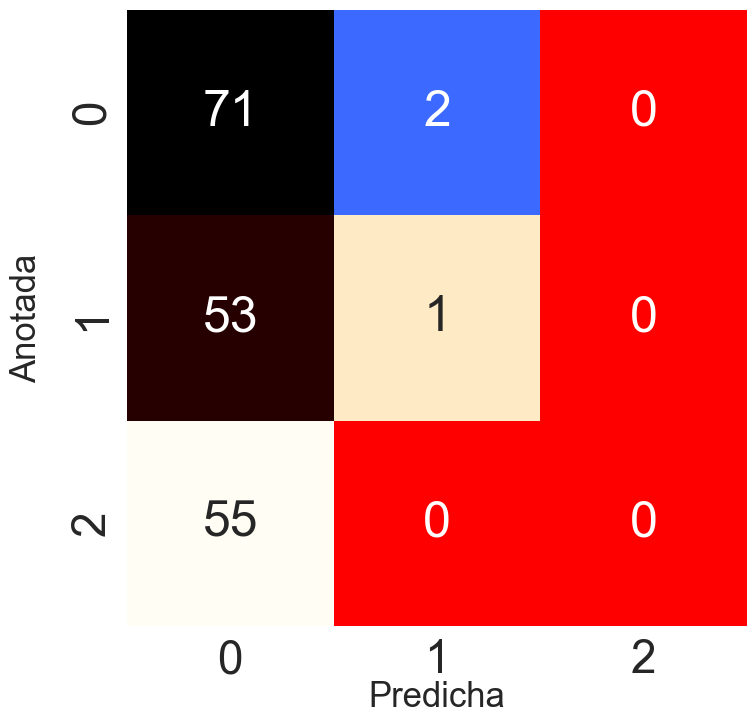

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

accuracy = accuracy_score(yTest, yPredKN)
precision = precision_score(yTest, yPredKN,average='weighted')
recall = recall_score(yTest, yPredKN,average='weighted')
f1score = f1_score(yTest, yPredKN,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(yTest, yPredKN)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)

Accuracy (TP/(n))= 0.4945054945054945
Precision (TP/(TP+FP)) = 0.3889218889218889
Recall (TP/(TP+FN)) = 0.4945054945054945
F1 Score (2*(precision*recall)/(precision+recall)) = 0.42475891455483294


c:\Users\Nauzet\Documents\VirtualEnviroments\VPD\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(38.25, 0.5, 'Anotada')

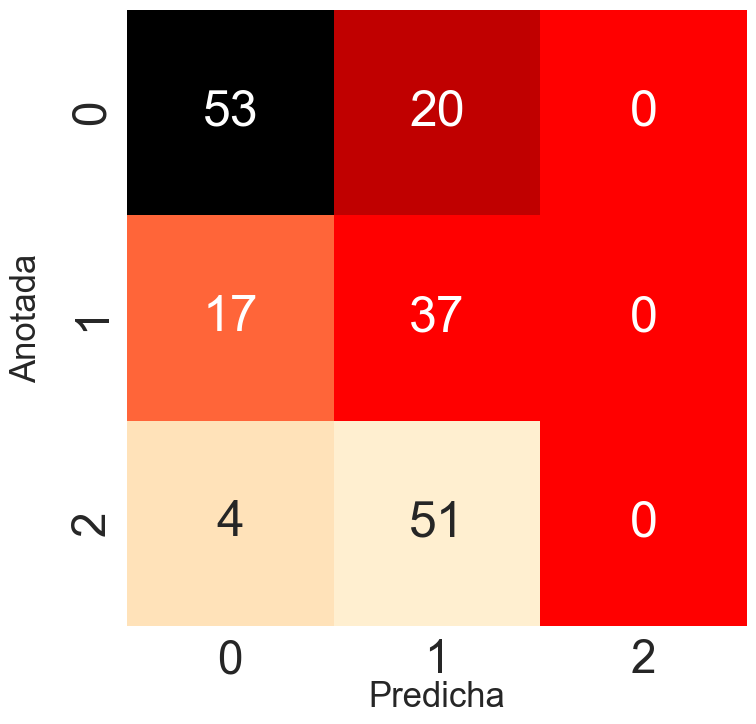

In [26]:
accuracy = accuracy_score(yTest, yPredSvcClass)
precision = precision_score(yTest, yPredSvcClass,average='weighted')
recall = recall_score(yTest, yPredSvcClass,average='weighted')
f1score = f1_score(yTest, yPredSvcClass,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(yTest, yPredSvcClass)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)

Accuracy (TP/(n))= 0.3021978021978022
Precision (TP/(TP+FP)) = 0.09132351165318198
Recall (TP/(TP+FN)) = 0.3021978021978022
F1 Score (2*(precision*recall)/(precision+recall)) = 0.14026058329855795


c:\Users\Nauzet\Documents\VirtualEnviroments\VPD\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(38.25, 0.5, 'Anotada')

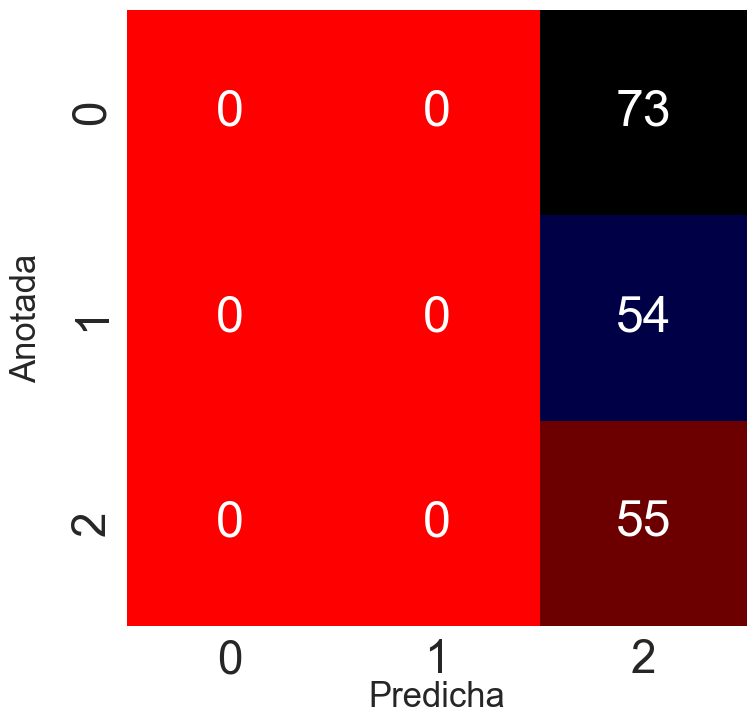

In [27]:
accuracy = accuracy_score(yTest, yPredSvcClassRbf)
precision = precision_score(yTest, yPredSvcClassRbf,average='weighted')
recall = recall_score(yTest, yPredSvcClassRbf,average='weighted')
f1score = f1_score(yTest, yPredSvcClassRbf,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(yTest, yPredSvcClassRbf)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)

Accuracy (TP/(n))= 0.521978021978022
Precision (TP/(TP+FP)) = 0.38741881228269615
Recall (TP/(TP+FN)) = 0.521978021978022
F1 Score (2*(precision*recall)/(precision+recall)) = 0.4412461280330408


c:\Users\Nauzet\Documents\VirtualEnviroments\VPD\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(38.25, 0.5, 'Anotada')

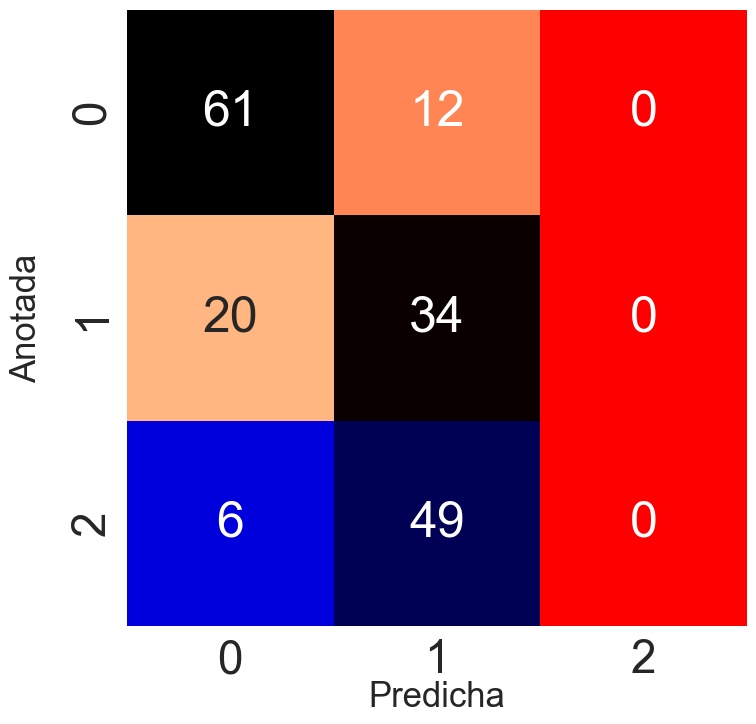

In [28]:
accuracy = accuracy_score(yTest, yPredRfcClass)
precision = precision_score(yTest, yPredRfcClass,average='weighted')
recall = recall_score(yTest, yPredRfcClass,average='weighted')
f1score = f1_score(yTest, yPredRfcClass,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(yTest, yPredRfcClass)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)